In [43]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

In [4]:
# Extract dataset
ZIP_FILE = "Teeth Dataset.zip"
EXTRACT_PATH = "./Teeth_Dataset"

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall("./")

## Dataset Paths

In [5]:
DATASET_DIR = EXTRACT_PATH
TRAIN_DIR = os.path.join(DATASET_DIR, "Training")
VAL_DIR = os.path.join(DATASET_DIR, "Validation")
TEST_DIR = os.path.join(DATASET_DIR, "Testing")

## Data Preprocessing

In [33]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(train_generator.class_indices.keys())  
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


## Model Architecture

In [34]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [35]:
# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,787,335 (98.37 MB)

 Trainable params: 25,786,375 (98.37 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile Model


In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Callbacks

In [37]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## Train Model


In [38]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2624 - loss: 2.3780
Epoch 1: val_loss improved from inf to 2.98540, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.2628 - loss: 2.3745 - val_accuracy: 0.1449 - val_loss: 2.9854 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4060 - loss: 1.6782
Epoch 2: val_loss improved from 2.98540 to 2.90935, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4060 - loss: 1.6778 - val_accuracy: 0.1518 - val_loss: 2.9093 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4500 - loss: 1.4876
Epoch 3: val_loss improved from 2.90935 to 2.61728, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4502 - loss: 1.4871 - val_accuracy: 0.1722 - val_loss: 2.6173 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5129 - loss: 1.32

## Plot Accuracy and Loss

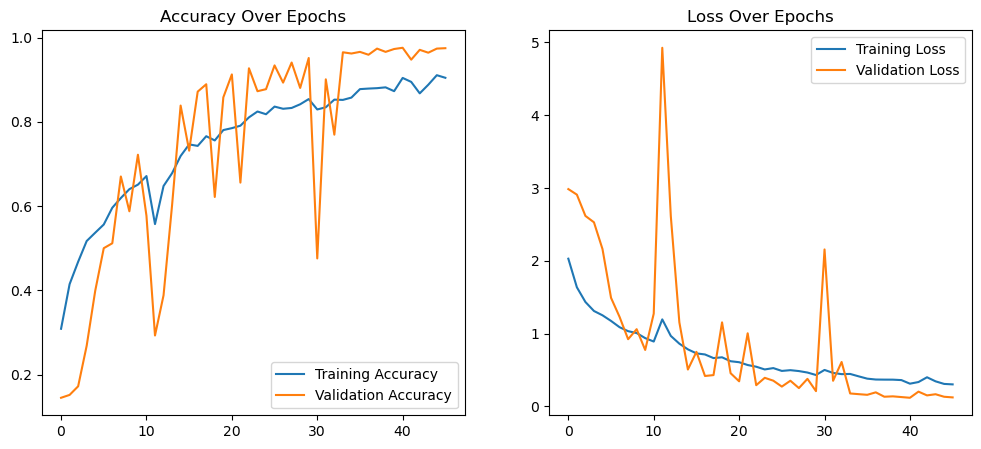

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

## Load Best Model


In [40]:
model = load_model('best_model.keras')


## Evaluate Model


In [41]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.9733 - loss: 0.1218
Test Loss: 0.1191, Test Accuracy: 0.9728


## Confusion Matrix

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step


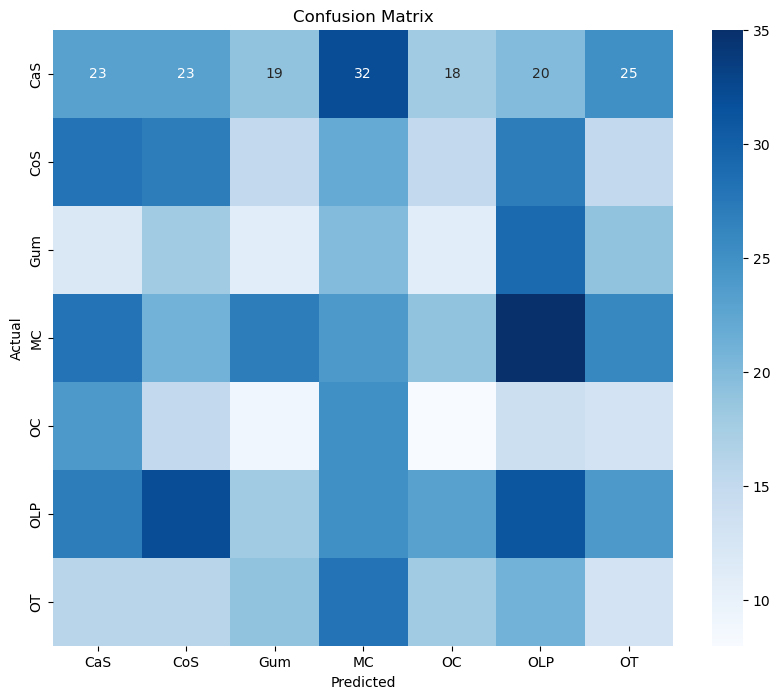

In [44]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
## Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

         CaS       0.15      0.14      0.14       160
         CoS       0.18      0.18      0.18       149
         Gum       0.09      0.09      0.09       120
          MC       0.14      0.13      0.13       180
          OC       0.07      0.07      0.07       108
         OLP       0.18      0.17      0.17       180
          OT       0.10      0.10      0.10       131

    accuracy                           0.13      1028
   macro avg       0.13      0.13      0.13      1028
weighted avg       0.13      0.13      0.13      1028

